In [210]:
# import libraries
# python staples
import numpy as np
import pandas as pd
from pandas.core import datetools
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
# scikitlearn

from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
# seaborn plotting
import seaborn as sns
# use matplot |in jupyter notebook
#%matplotlib inline
from xgboost import XGBClassifier

In [164]:
def confusion_summary_binary(y_actual, y_pred, verbose):
    # get success and failur
    tot_tested = len(y_actual)
    tot_success = sum( y_actual )
    tot_fail = tot_tested - tot_success
    pred_success = sum( y_pred )
    pred_fail = tot_tested - pred_success
    # see how you did
    confusion_mat = confusion_matrix(y_actual, y_pred)
    confusion_mat_norm = confusion_mat / tot_tested
    accuracy = confusion_mat_norm[0,0] + confusion_mat_norm[1,1]
    recall = confusion_mat[0,0] / tot_success
    precision = confusion_mat[0,1] / pred_success
    f1 = 2 / ( 1/recall + 1/precision)
    summary = {"confusion": confusion_mat, "confusion_norm": confusion_mat_norm,
               "recall": recall, "precision": precision, "f1": f1,
               "accuracy": accuracy}
    if verbose == 1:
        print('accuracy = ', accuracy )
        print('recall = ', recall )
        print('precision = ', precision )
        print('f1 =', f1  )
    return summary

def clean_data( mydata, drop_list, verbose ):
    # some data is pointless, get rid of id
    mydata = mydata.drop( drop_list, axis=1 )
    if "Embarked" in mydata:
        embark_df=pd.get_dummies(mydata.Embarked,prefix='embark')
        mydata=mydata.join(embark_df)
        mydata=mydata.drop('Embarked',axis=1)
    if "Cabin" in mydata:
        mydata.Cabin = mydata.Cabin.fillna('N')
        mydata.Cabin = mydata.Cabin.apply(lambda y: y[0])
        cabin_df = pd.get_dummies(mydata.Cabin,prefix='deck')
        if ('deck_T' not in cabin_df.columns):
            cabin_df = cabin_df.join(pd.Series(np.zeros(cabin_df.shape[0]),index=cabin_df.index,name='deck_T'))
        mydata = mydata.join(cabin_df)
        mydata=mydata.drop('Cabin',axis=1)
    # find isnan value
    if verbose == 1:
        print( 'before clean isnan check:\n', mydata.isna().any() )
    # turn male/female, embarked to a number
    mydata.loc[mydata.Sex == 'female','Sex' ] = 0
    mydata.loc[mydata.Sex == 'male','Sex' ] = 1
    # replace nan with average
    mydata.loc[mydata.Age.isnull(),'Age']  = np.mean( mydata.Age[~mydata.Age.isna()] )
    mydata.loc[mydata.Fare.isnull(),'Fare']  = np.mean( mydata.Fare[~mydata.Fare.isna()] )
    #normalize
    mydata.Age = ( mydata.Age - mydata.Age.mean() ) / mydata.Age.std()
    mydata.Fare = ( mydata.Fare - mydata.Fare.mean() ) / mydata.Fare.std()
    if verbose:
        print('after clean isnan check:\n', mydata.isna().any() )
        print( 'Cleaned data:', mydata.iloc[0] )
    return mydata

def sklearn_fit( fitmodel, x_train, y_train, x_cv, y_cv, verbose ):
    fitmodel.fit(x_train, y_train)
    prediction = fitmodel.predict(x_cv)
    accuracy = get_accuracy( y_cv, prediction )
    model = {'prediction': prediction, 'accuracy': accuracy }
    return model

def get_accuracy( y_actual, y_pred ):
    return np.sum( y_actual == y_pred) / np.size( y_actual)

def get_rand_train_inds( num_points, train_frac ):
        num_train = np.round( num_tot * train_frac )
        ind_all = np.arange(num_points)
        ind_train = np.random.choice(int(num_points), int(num_train), replace=False)
        ind_cv = np.delete( ind_all, ind_train )
        return ind_train, ind_cv

In [165]:
# grab the data and put it in a pandas dataframe
df_train_all = pd.read_csv('train.csv')
df_test_all = pd.read_csv('test.csv')
# print some info
print('Original train data set:\n\n', df_train_all.iloc[0])
print('Original test data set:\n\n', df_test_all.iloc[0])
num_features = len( df_train_all.columns ) - 1
print('\n features:', num_features, 'num_train', len(df_train_all.PassengerId),
      'num_test', len(df_test_all.PassengerId) )

Original train data set:

 PassengerId                          1
Survived                             0
Pclass                               3
Name           Braund, Mr. Owen Harris
Sex                               male
Age                                 22
SibSp                                1
Parch                                0
Ticket                       A/5 21171
Fare                              7.25
Cabin                              NaN
Embarked                             S
Name: 0, dtype: object
Original test data set:

 PassengerId                 892
Pclass                        3
Name           Kelly, Mr. James
Sex                        male
Age                        34.5
SibSp                         0
Parch                         0
Ticket                   330911
Fare                     7.8292
Cabin                       NaN
Embarked                      Q
Name: 0, dtype: object

 features: 11 num_train 891 num_test 418


In [168]:
# clean data
drop_list = ['PassengerId','Name','Ticket', 'Cabin']
# break the y data to train, validation set
train_frac = 0.66;
num_tot = len(df_train_all.index)
y_data = df_train_all.Survived
# clean it
df_data = clean_data(df_train_all, drop_list, 0)
# separate into training sets
x_data = df_data.drop('Survived', axis=1)
x_test = clean_data(df_test_all, drop_list, 0)
# print some info
num_features_test = len(x_test.columns )
num_features_train = len( x_data.columns )
print( 'Data set:\n', x_data.iloc[0])
print('\n test samples:', len(x_test.index))
print('\n train samples:', len(x_data.index))
print('\n features:', num_features_test, num_features_train )

Data set:
 Pclass      3.000000
Sex         1.000000
Age        -0.592148
SibSp       1.000000
Parch       0.000000
Fare       -0.502163
embark_C    0.000000
embark_Q    0.000000
embark_S    1.000000
Name: 0, dtype: float64

 test samples: 418

 train samples: 891

 features: 9 9


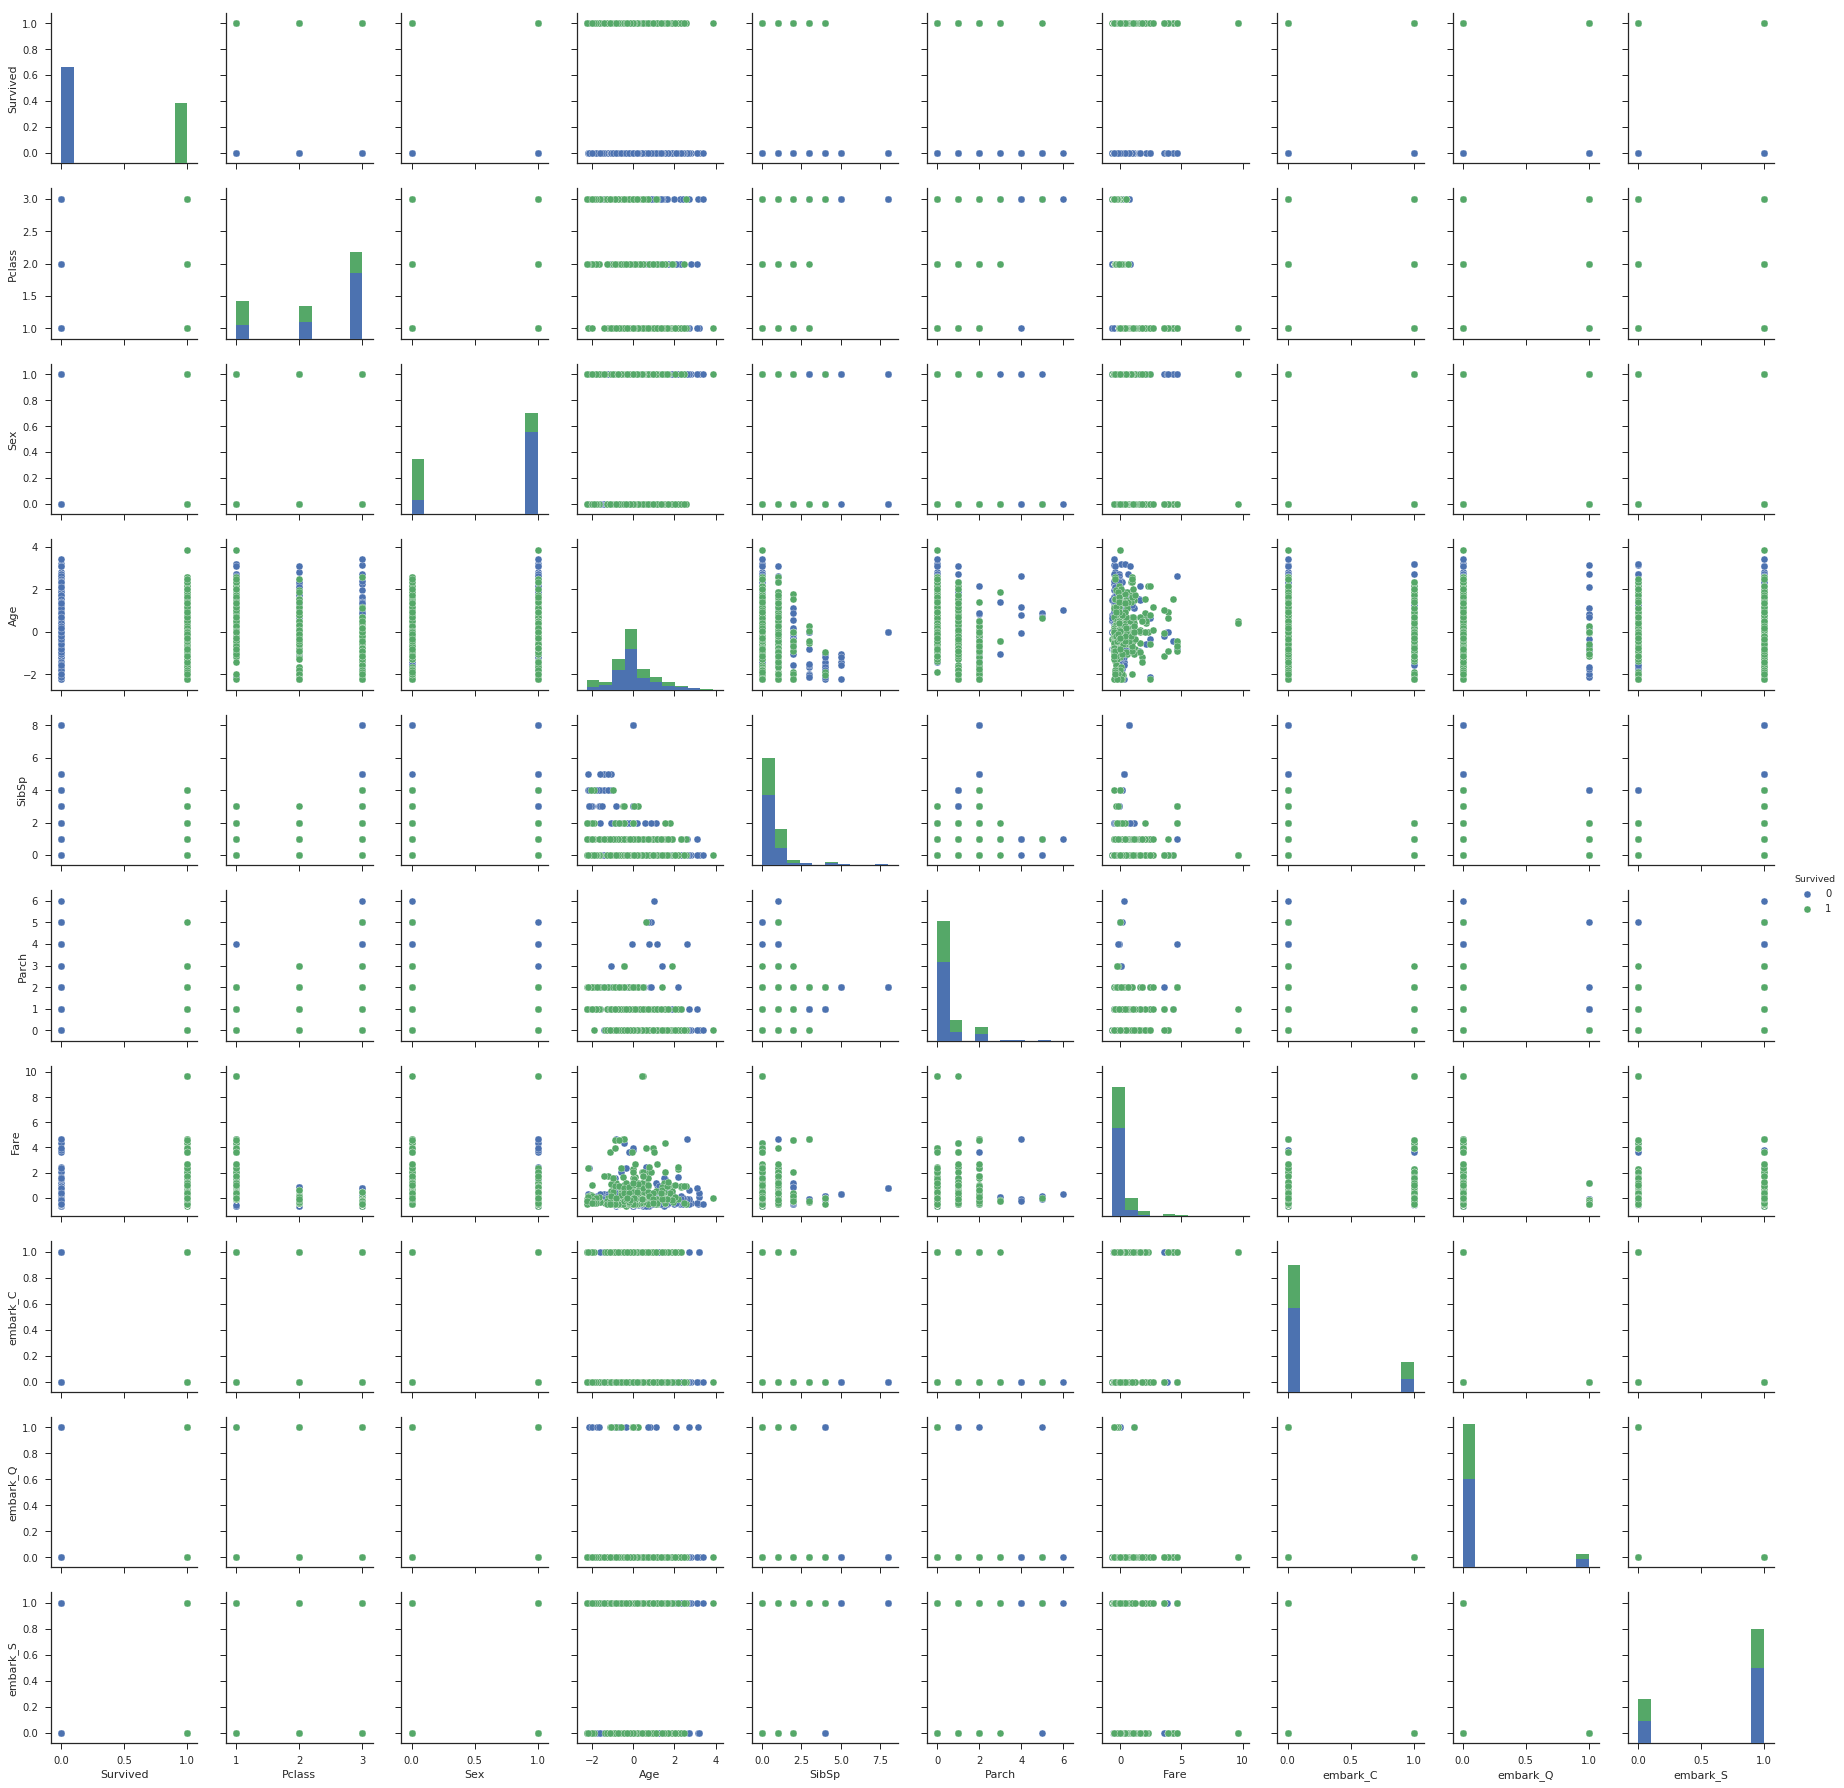

In [5]:
sns.set(style="ticks")
sns.pairplot(df_data, hue='Survived')

Text(0.5,1,'PCA')

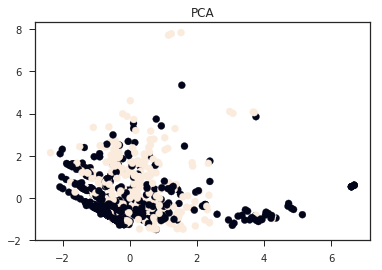

In [6]:
# Principal component analysis
# 2d
pca2 = PCA(n_components=2)
pca2.fit(x_train)
x_transform2 = pca2.transform(x_data)
plt.scatter( x_transform2[:,0], x_transform2[:,1], c = y_data)
plt.title('PCA')

In [162]:
# Logistical fit using sm.Logit
logistic2 = sm.Logit(y_data, x_data)
# fit the model
result = logistic2.fit()
print( result.summary2() )

NameError: name 'y_data' is not defined

In [11]:
# fit them all
verbose = 0
# sci-kit learn logistic regression
logistic = linear_model.LogisticRegression()
# linear discriminant analysis
lda = LinearDiscriminantAnalysis()
# SVM: linear kernal
linear_svc = SVC(kernel='linear')
# SVM: gaussian kernal
gaussian_svc = SVC(kernel='rbf')
# random forest
randfor = RandomForestClassifier(max_depth=2, random_state=0)
# knn 
n_neighbors = 12
knn = KNeighborsClassifier(n_neighbors)
# build a list
list_o_fits = [logistic, lda, linear_svc, gaussian_svc, randfor, knn]
# fit_results = [sklearn_fit(a_fit, x_train, y_train, x_cv, y_cv, verbose) for a_fit in list_o_fits]
# accuracy = np.array( [a_fit["accuracy"] for a_fit in fit_results] );
# best_model = {'accuracy': accuracy.max(), 'list_ind': accuracy.argmax(), 'class_name': list_o_fits[accuracy.argmax()].__class__ };
# print( best_model )

In [12]:
# try this over many random sets of the data
num_trials = 10
accuracy_mat = np.zeros( (num_trials, len(list_o_fits) ))
for i in range(num_trials):
    # separate into training sets
    ind_train, ind_cv = get_rand_train_inds( num_tot, train_frac )
    x_train = x_data.iloc[ind_train]
    x_cv = x_data.iloc[ind_cv]
    y_train = df_train_all.Survived.iloc[ind_train]
    y_cv = df_train_all.Survived.iloc[ind_cv]
    # fit
    fit_results = [sklearn_fit(a_fit, x_train, y_train, x_cv, y_cv, verbose) for a_fit in list_o_fits]
    accuracy_mat[i,:] = np.array( [a_fit["accuracy"] for a_fit in fit_results] );


In [38]:
# average for the best
print(accuracy_mat)
mean_accuracy = accuracy_mat.mean(axis=0)
best_model = {'accuracy': mean_accuracy.max(), 'list_ind': mean_accuracy.argmax(), 'class_name': list_o_fits[mean_accuracy.argmax()].__class__ };
print( best_model )

[[ 0.82508251  0.81518152  0.8019802   0.86468647  0.79537954  0.82838284]
 [ 0.77887789  0.75907591  0.76567657  0.81848185  0.7689769   0.8349835 ]
 [ 0.82838284  0.83828383  0.79867987  0.82838284  0.81848185  0.79867987]
 [ 0.8019802   0.79537954  0.79207921  0.82838284  0.7689769   0.79537954]
 [ 0.79207921  0.78547855  0.78217822  0.82178218  0.76237624  0.81188119]
 [ 0.79537954  0.78547855  0.7689769   0.81848185  0.77887789  0.78547855]
 [ 0.8019802   0.79867987  0.8019802   0.81848185  0.81848185  0.80858086]
 [ 0.80528053  0.80858086  0.81188119  0.82838284  0.79867987  0.78877888]
 [ 0.77557756  0.78217822  0.76567657  0.8019802   0.76237624  0.77887789]
 [ 0.81188119  0.8019802   0.78217822  0.84488449  0.78217822  0.83828383]]
{'list_ind': 3, 'class_name': <class 'sklearn.svm.classes.SVC'>, 'accuracy': 0.82739273927392742}


In [14]:
# error analysis for knn
max_neighbors = 20
num_fits = max_neighbors
num_trials = 20
knn_neighbors = np.arange(1,max_neighbors+1)
accuracy_knn_train = np.zeros( num_fits )
accuracy_knn_cv = np.zeros( num_fits )
# loop over numer of neighbors
for nn_ind, nn in enumerate(knn_neighbors):
    knn_temp = KNeighborsClassifier(nn) 
    accuracy_trail_train = np.zeros( (num_trials))
    accuracy_trail_cv = np.zeros( (num_trials))
    for i in range(num_trials):
        # separate into training sets
        ind_train, ind_cv = get_rand_train_inds( num_tot, train_frac )
        x_train = x_data.iloc[ind_train]
        x_cv = x_data.iloc[ind_cv]
        y_train = df_train_all.Survived.iloc[ind_train]
        y_cv = df_train_all.Survived.iloc[ind_cv]
        # fit it
        knn_temp.fit( x_train, y_train )
        pred_train = knn_temp.predict(x_train)
        pred_cv = knn_temp.predict(x_cv)
        accuracy_trail_train[i] = get_accuracy( y_train, pred_train )
        accuracy_trail_cv[i] = get_accuracy( y_cv, pred_cv )
    accuracy_knn_train[nn_ind] = np.average(accuracy_trail_train)
    accuracy_knn_cv[nn_ind] = np.average(accuracy_trail_cv)


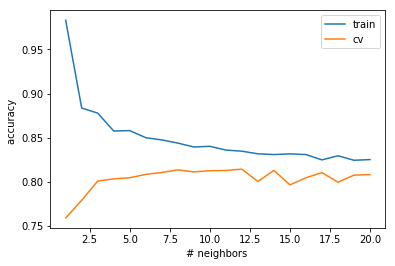

In [14]:
plt.plot( knn_neighbors, accuracy_knn_train, label='train')
plt.plot( knn_neighbors, accuracy_knn_cv, label='cv')
plt.xlabel('# neighbors ')
plt.ylabel('accuracy ')
plt.legend()


In [66]:
# regularization
alpha_fit = np.arange(20)
num_fits = len(alpha_fit)
num_trials = 20
accuracy_reg_train = np.zeros( num_fits )
accuracy_reg_cv = np.zeros( num_fits )
# loop over numer of neighbors
for nn_ind, nn in enumerate(alpha_fit):
    fit_temp = RidgeClassifier(alpha=nn) 
    accuracy_trial_train = np.zeros( (num_trials,))
    accuracy_trial_cv = np.zeros( (num_trials,))
    for i in range(num_trials):
         # separate into training sets
        ind_train, ind_cv = get_rand_train_inds( num_tot, train_frac )
        x_train = x_data.iloc[ind_train]
        x_cv = x_data.iloc[ind_cv]
        y_train = df_train_all.Survived.iloc[ind_train]
        y_cv = df_train_all.Survived.iloc[ind_cv]
        # fit it
        fit_temp.fit(x_train, y_train)
        pred_train = fit_temp.predict(x_train)
        pred_cv = fit_temp.predict(x_cv)
        accuracy_trial_train[i] = get_accuracy(y_train, pred_train)
        accuracy_trial_cv[i] = get_accuracy(y_cv, pred_cv)
    accuracy_reg_train[nn_ind] = np.average(accuracy_trial_train)
    accuracy_reg_cv[nn_ind] = np.average(accuracy_trial_cv)

/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.6696565325813616e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)


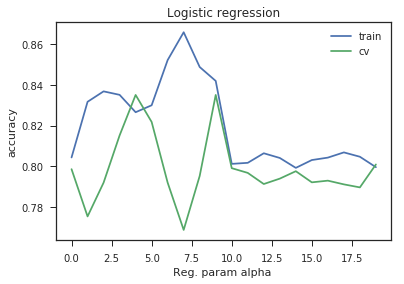

In [71]:
plt.plot( alpha_fit, accuracy_reg_train, label='train')
plt.plot( alpha_fit, accuracy_reg_cv, label='cv')
plt.xlabel('Reg. param alpha ')
plt.ylabel('accuracy')
plt.title('Logistic regression')
plt.legend()

In [72]:
# Forests
# split data into X and y
X = x_train
Y = y_train
# print(X)
#print(Y)
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, 
                                                    random_state=seed)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, Y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.38%


In [101]:
num_trials

1

In [73]:
# Neural nets

In [106]:
net_size = 10 * (np.arange(10) + 1)
# try this over many random sets of the data
num_trials = 20
accuracy_reg_train = np.zeros(shape=(np.shape(net_size)))
accuracy_reg_cv = np.zeros(shape=(np.shape(net_size)))
# loop over numer of neighbors
for nn_ind, nn in enumerate(net_size):
    print('net size', nn)
    fit_temp = mlp_class = MLPClassifier(hidden_layer_sizes=(nn),
                                        max_iter=500)
    accuracy_trial_train = np.zeros( (num_trials,))
    accuracy_trial_cv = np.zeros( (num_trials,))
    for i in range(num_trials):
        # separate into training sets
        ind_train, ind_cv = get_rand_train_inds( num_tot, train_frac )
        x_train = x_data.iloc[ind_train]
        x_cv = x_data.iloc[ind_cv]
        y_train = df_train_all.Survived.iloc[ind_train]
        y_cv = df_train_all.Survived.iloc[ind_cv]
        # fit it
        fit_temp.fit(x_train, y_train)
        pred_train = fit_temp.predict(x_train)
        pred_cv = fit_temp.predict(x_cv)
        accuracy_trial_train[i] = get_accuracy(y_train, pred_train)
        accuracy_trial_cv[i] = get_accuracy(y_cv, pred_cv)
    accuracy_reg_train[nn_ind] = np.average(accuracy_trial_train)
    accuracy_reg_cv[nn_ind] = np.average(accuracy_trial_cv)

net size 10
net size 20
net size 30
net size 40


/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


net size 50
net size 60
net size 70
net size 80
net size 90
net size 100


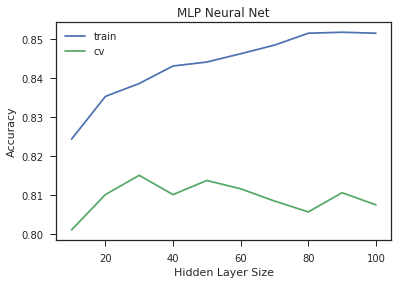

In [107]:
plt.plot(net_size, accuracy_reg_train, label='train')
plt.plot(net_size, accuracy_reg_cv, label='cv')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Accuracy')
plt.title('MLP Neural Net')
plt.legend()

## Learning Curve

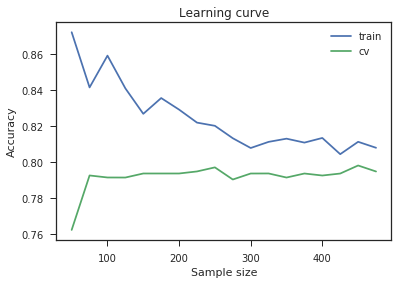

In [203]:
train_sizes = 25 * np.arange(2, 20)
_, train_scores, valid_scores = learning_curve(
    LogisticRegression(), x_data, y_data, train_sizes=train_sizes, cv=10)
train_scores_ave = np.mean(train_scores, axis=1)
valid_scores_ave = np.mean(valid_scores, axis=1)
plt.plot(train_sizes, train_scores_ave, label='train')
plt.plot(train_sizes, valid_scores_ave, label='cv')
plt.xlabel('Sample size')
plt.ylabel('Accuracy')
plt.title('Learning curve')
plt.legend()

In [184]:
print(train_scores)

[[ 0.84        0.88        0.88        0.88        0.88      ]
 [ 0.85        0.85        0.85        0.85        0.85      ]
 [ 0.78181818  0.84545455  0.84545455  0.84545455  0.84545455]]


## Logistic Regression Regularization

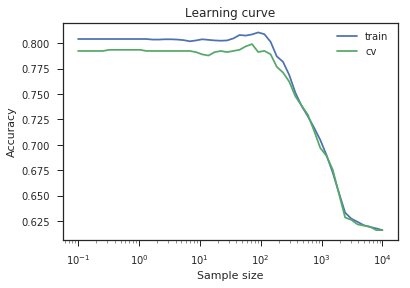

In [224]:
# alpha_test = np.linspace(0, 20)
alpha_test = np.logspace(-1, 4)
train_scores, valid_scores = validation_curve(RidgeClassifier(), x_data, y_data, "alpha",
                                              alpha_test, cv=5)
train_scores_ave = np.mean(train_scores, axis=1)
valid_scores_ave = np.mean(valid_scores, axis=1)    
plt.semilogx(alpha_test, train_scores_ave, label='train')
plt.semilogx(alpha_test, valid_scores_ave, label='cv')
plt.xlabel('Sample size')
plt.ylabel('Accuracy')
plt.title('Learning curve')
plt.legend()

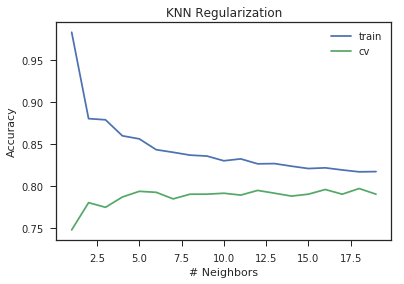

In [219]:
param_var = np.arange(1, 20)
train_scores, valid_scores = validation_curve(KNeighborsClassifier(), x_data, y_data, "n_neighbors",
                                              param_var, cv=5)
train_scores_ave = np.mean(train_scores, axis=1)
valid_scores_ave = np.mean(valid_scores, axis=1)    
plt.plot(param_var, train_scores_ave, label='train')
plt.plot(param_var, valid_scores_ave, label='cv')
plt.xlabel('# Neighbors')
plt.ylabel('Accuracy')
plt.title('KNN Regularization')
plt.legend()